

# Neural Networks using Keras 



### Outline
Our goal is to tune the Apple Store NN for multi-class classification. We need to make several decisions when configuring our NN and focus on finding the optimal parameters for the
 - number of hidden layers
 - number of neurons in hidden layers
 - activation functions
 - type of weight initialization
 - learning rate and momentum
 - optimizer
 - size of batch
 - number of epochs
 - regularization (dropout)



In a first Part of this Notebook we will use Grid Search for Hyperparameter Tuning.

Then in a second Part we will use Keras-Tuner

In [1]:
# Setting up the environment: import standard libraries and load the data. 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#This package provides utilities for Keras, such as modified callbacks, data genereators, encoder, etc.
from tensorflow.keras import utils


## Use case: app rating analysis
NNs often **solve classification problems with many classes**. To illustrate their functioning in a context that is more related to NLP examples,we introduce the data set concerned with app ratings. The **original data is available on Kaggle**. There, you also find a data dictionary with some information on the variables. However, the variable names are rather self-explanatory. A cleaned version of the data is available in this folder. The easiest way for you is to use the cleaned version but feel very free to play around with the version on Kaggle. You can find a Python script that starts from the original data and goes through a couple of pre-processing operations to produce the version we use below (**app_store_dpp.py**).

In [2]:
# Load dataset and set app name as index

app = pd.read_csv("https://raw.githubusercontent.com/murpi/wilddata/master/quests/AppleStore_prep.csv", 
                  index_col=False, sep='\t', encoding='utf-8')
app = app.set_index('track_name')
app.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7197 entries, PAC-MAN Premium to Escape the Sweet Shop Series
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   size_bytes                     7197 non-null   float64
 1   price                          7197 non-null   float64
 2   rating_count_tot               7197 non-null   float64
 3   sup_devices.num                7197 non-null   float64
 4   ipadSc_urls.num                7197 non-null   float64
 5   lang.num                       7197 non-null   float64
 6   vpp_lic                        7197 non-null   float64
 7   currency_USD                   7197 non-null   int64  
 8   cont_rating_12+                7197 non-null   int64  
 9   cont_rating_17+                7197 non-null   int64  
 10  cont_rating_4+                 7197 non-null   int64  
 11  cont_rating_9+                 7197 non-null   int64  
 12  prime_genre_Boo

So **36 columns**, **one of which is the target variable**. We consider the **user rating as our target** and will try to set up a NN that predict the rating from the app characteristics including information on its price, genre, etc.

Let's have a quick look at the target variable. Note that we that we have reduced the number of rating classes compared to the original version of the data on Kaggle (see app_store_dpp.py for details).  


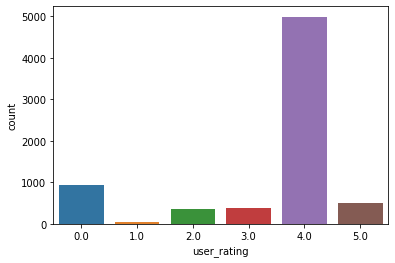

In [3]:
# Inspect the target
import seaborn as sns
sns.countplot(x=app["user_rating"]);

In [4]:
app["user_rating"]

track_name
PAC-MAN Premium                                       4.0
Evernote - stay organized                             4.0
WeatherBug - Local Weather, Radar, Maps, Alerts       4.0
eBay: Best App to Buy, Sell, Save! Online Shopping    4.0
Bible                                                 4.0
                                                     ... 
Kubik                                                 4.0
VR Roller-Coaster                                     4.0
Bret Michaels Emojis + Lyric Keyboard                 4.0
VR Roller Coaster World - Virtual Reality             4.0
Escape the Sweet Shop Series                          5.0
Name: user_rating, Length: 7197, dtype: float64

In [5]:
# Prepare the target variable
# LabelEncoder() transforms a string vector to a num vector
encoder = LabelEncoder()
#fit label encoder
encoder.fit(app["user_rating"])
#transform and return encoded labels
encoder.transform(app["user_rating"])




array([4, 4, 4, ..., 4, 4, 5])

In [6]:
dummy_y = utils.to_categorical(encoder.transform(app["user_rating"])).astype(int)
dummy_y

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])

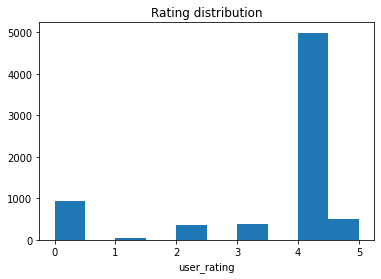

(5037, 35)
(5037, 6)


In [7]:
plt.hist(dummy_y.argmax(axis=1))
plt.xlabel('user_rating')
plt.title('Rating distribution')
plt.show();

# Let's split our data set

#Seed function is used to save the state of a random function, so that it can generate same random numbers on multiple executions of the code on the same machine or on different machines (for a specific seed value)
seed=42

X = app.iloc[:,:-1].values
y = dummy_y

# Keep in mind that this data set is already standardized, which leads to a leakage of information from train set to test set
# When you are working with a dataset, make sure you standardize the variables in test set according to the parameters of the train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)
    
print (X_train.shape)
print(y_train.shape) 
#X.head(5)

### Preparing the Keras framework ###

Today we will revise the architecture of our basic neural network and look more into the tuning of hyperparameters.



In [8]:
nb_units = 128
# And finally the outout layer
nb_classes = y.shape[1]

In [9]:
# Import Keras
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD


model = Sequential()
model.add(Dense(nb_units, activation='relu',bias_initializer='zeros',kernel_initializer=tf.keras.initializers.he_normal(seed=seed), input_shape=(X.shape[1],)))
#model.add(Dropout(0.1))
model.add(Dense(nb_units, activation='relu',bias_initializer='zeros',kernel_initializer=tf.keras.initializers.he_normal(seed=seed)))
#model.add(Dropout(0.1))
model.add(Dense(nb_classes, activation='softmax'))

model.summary()

batch_size = 56 #1 for online SGD

# example: start tarining the model up until 30 epochs and plot the training loss values and validation loss values against number of epochs.
epochs = 30


model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01), metrics=['accuracy'])
# Fit the model
story = model.fit(X_train, y_train, #name model differently
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                 validation_data=(X_test, y_test))
                    #validation_split=0.33)#validation_data=(X_test, y_test)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4608      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 21,894
Trainable params: 21,894
Non-trainable params: 0
_________________________________________________________________


In [10]:
def show_history(story):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)
    ax1.plot(story.history['accuracy'])
    ax1.plot(story.history['val_accuracy'])
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['train_accuracy', 'test_accuracy'], loc='best')
    ax1.set_title('Accuracy evolution during NN training')
    
    ax2.plot(story.history['loss'])
    ax2.plot(story.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during NN training')
    plt.show()


In [11]:
score = model.evaluate(X_test, y_test, verbose=0)

Test loss: 0.9585330486297607
Test accuracy: 0.7083333134651184


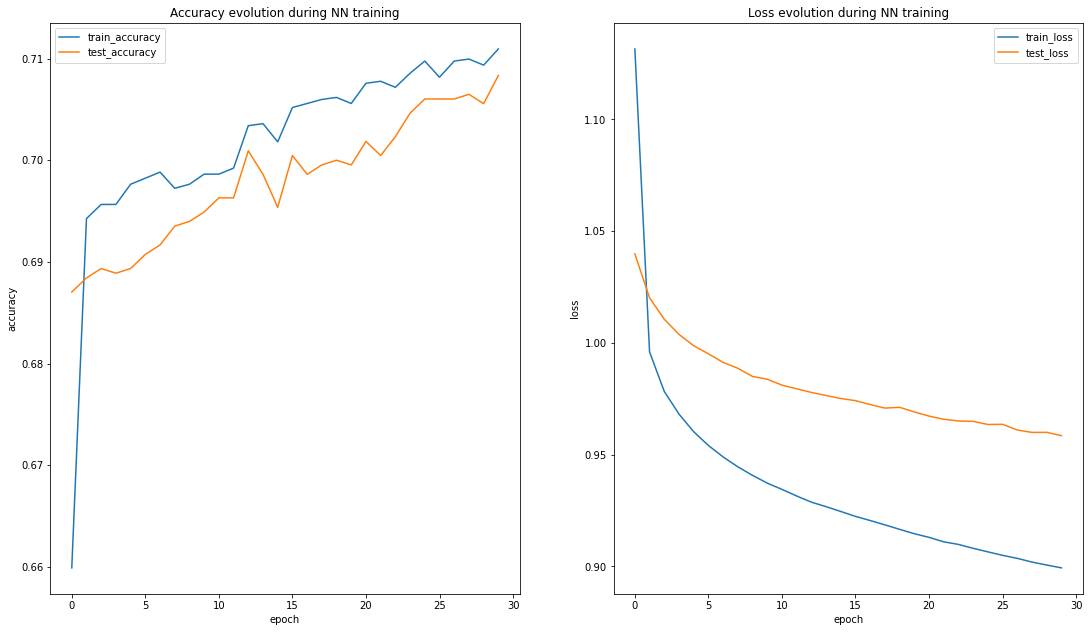

In [12]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])
show_history(story)

# Part 1: Hyperparameter optimization with Keras





We will start with the old-fashioned way with Scikit Learn and will first show you an example of how to use GridSearch with two groups of hyperparameters: batches/epochs and optimizer algorithms. 

In [13]:
import tensorflow.keras
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers

In [14]:
#We will use the architecture we had before and wrap it into the function called 'netowork ' (or whatever you want to call it)

def network():
    
    model = Sequential()
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=tensorflow.keras.initializers.he_normal(seed=seed),  input_shape=(X.shape[1],)))
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=tensorflow.keras.initializers.he_normal(seed=seed)))
    model.add(Dense(6, activation='softmax',kernel_initializer=tensorflow.keras.initializers.he_normal(seed=seed)))
    
    model.compile(optimizer=optimizers.SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy']) #nothing changes here

    return model

# Now we will plug it into Keras Classifier Wrapper 
model = KerasClassifier(build_fn=network, verbose=0)

In [15]:
# Let's define the grid search parameters
batchsize = [32, 64, 128, 256, 512]
epochs = [10,30,60,70]

In [16]:
#Set the grid
param_grid = dict(batch_size=batchsize, epochs=epochs)# setting a dictionary to store the results
param_grid 

{'batch_size': [32, 64, 128, 256, 512], 'epochs': [10, 30, 60, 70]}

In [17]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,cv=3) #parallelization, here using all processors
results = grid.fit(X_train, y_train) #remember that we don't want to use the test set in CV
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.708557 using {'batch_size': 32, 'epochs': 70}


In [18]:
#Let's now take this knowledge and apply it to our optimizers tuning

def optim (optimizer='SGD'):
    model = Sequential()
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=tf.keras.initializers.he_normal(seed=seed),  input_shape=(X.shape[1],)))
  
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=tf.keras.initializers.he_normal(seed=seed)))
 
    model.add(Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.he_normal(seed=seed)))
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model

model = KerasClassifier(build_fn=optim, epochs=70, batch_size=32, verbose=0)
# define the grid search parameters
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizers) # setting a dictionary to store the results
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

# Our results (reember these are the resultson the hold-out data)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.709748 using {'optimizer': 'SGD'}


Now continue using Grid Search to tune the Learning Rate and Momentum:

In [19]:
def make_model_lr_momentum(lr=0.01, momentum=0.0):

    optimizer=tf.keras.optimizers.SGD(
        learning_rate=lr,
        momentum=momentum
    )

    model = Sequential()
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=tf.keras.initializers.he_normal(seed=seed),  input_shape=(X.shape[1],)))
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=tf.keras.initializers.he_normal(seed=seed)))
    model.add(Dense(6, activation='softmax',kernel_initializer=tf.keras.initializers.he_normal(seed=seed))) 
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model



model = KerasClassifier(build_fn=make_model_lr_momentum, epochs=70, batch_size=32, verbose=0)

lr_grid = [0.01, 0.001, 0.0001]
momentum_grid = [0, 0.2, 0.5, 0.8]

param_grid = dict(lr=lr_grid, momentum=momentum_grid)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.711138 using {'lr': 0.01, 'momentum': 0}


Use Grid Search to tune the Network Weight Initialization:

In [20]:
def make_model_w_init(initializer):

    optimizer=tf.keras.optimizers.SGD(
        learning_rate=0.01,
        momentum=0.2
    )

    model = Sequential()
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=initializer,  input_shape=(X.shape[1],)))
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=initializer))
    model.add(Dense(6, activation='softmax',kernel_initializer=initializer)) 
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model


model = KerasClassifier(build_fn=make_model_w_init, epochs=70, batch_size=32, verbose=0)

init_grid=[
    "random_normal",
    "random_uniform",
    "truncated_normal",
    "zeros",
    "ones",
    "glorot_normal",
    "glorot_uniform",
    "he_normal",
    "he_uniform",
    "identity" 
    ]

param_grid = dict(initializer=init_grid)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.711932 using {'initializer': 'he_normal'}


Use Grid Search to tune the Neuron Activation Function


In [21]:
def make_model_activation(activation):

    optimizer=tf.keras.optimizers.SGD(
        learning_rate=0.01,
        momentum=0.2
    )

    initializer = "he_normal"

    model = Sequential()
    model.add(Dense(128, activation=activation,bias_initializer='zeros',kernel_initializer=initializer,  input_shape=(X.shape[1],)))
    model.add(Dense(128, activation=activation,bias_initializer='zeros',kernel_initializer=initializer))
    model.add(Dense(6, activation='softmax',kernel_initializer=initializer)) 
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model


model = KerasClassifier(build_fn=make_model_activation, epochs=70, batch_size=32, verbose=0)

act_grid=[
    "relu",
    "sigmoid",
    "softmax",
    "softplus",
    "softsign",
    "tanh",
    "selu",
    "elu",
    "exponential"
]

param_grid = dict(activation=act_grid)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.711733 using {'activation': 'elu'}


Use Grid Search to tune Dropout Regularization

In [22]:
def make_model_dropout(dropout):

    optimizer=tf.keras.optimizers.SGD(
        learning_rate=0.01,
        momentum=0.2
    )

    initializer = "he_normal"
    activation = "elu"

    model = Sequential()
    model.add(Dense(128, activation=activation,bias_initializer='zeros',kernel_initializer=initializer,  input_shape=(X.shape[1],)))
    model.add(Dropout(dropout))
    model.add(Dense(128, activation=activation,bias_initializer='zeros',kernel_initializer=initializer))
    model.add(Dropout(dropout))
    model.add(Dense(6, activation='softmax',kernel_initializer=initializer)) 
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model


model = KerasClassifier(build_fn=make_model_dropout, epochs=70, batch_size=32, verbose=0)

dropout_grid=[0.2, 0.4, 0.6, 0.8]

param_grid = dict(dropout=dropout_grid)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.711336 using {'dropout': 0.2}


Use Grid Search to tune the Number of Neurons in the Hidden Layer

In [25]:
def make_model_units(num):

    optimizer=tf.keras.optimizers.SGD(
        learning_rate=0.01,
        momentum=0.2
    )

    initializer = "he_normal"
    activation = "elu"
    dropout = 0.2

    model = Sequential()
    model.add(Dense(num, activation=activation,bias_initializer='zeros',kernel_initializer=initializer,  input_shape=(X.shape[1],)))
    model.add(Dropout(dropout))
    model.add(Dense(num, activation=activation,bias_initializer='zeros',kernel_initializer=initializer))
    model.add(Dropout(dropout))
    model.add(Dense(6, activation='softmax',kernel_initializer=initializer)) 
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model


model = KerasClassifier(build_fn=make_model_units, epochs=70, batch_size=32, verbose=0)

num_grid=[4, 8, 16, 32, 64, 128, 256, 512]

param_grid = dict(num=num_grid)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.710939 using {'num': 512}


# Part 2:  Keras Tuner

In [29]:
import keras_tuner as kt

from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

Read through the Keras Tuner Documentation and build a RandomSearch. This hyperparameter tuning method randomly tries a combination of hyperparameters from a given search space. To use this method in keras tuner, first define a tuner using one of the available [Tuners](https://keras-team.github.io/keras-tuner/documentation/tuners/).


In [34]:
# We need first create a Hypermodel.

# Here I will make a subclass of Hypermodel.
# A HyperModel subclass only needs to implement a build(self, hp) method,
# which creates a keras.Model using the hp argument to define the hyperparameters
# and returns the model instance.

class MyHyperModel(kt.HyperModel):
    def build(self, hp):

        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.2)
        initializer = "he_normal"
        activation = hp.Choice("activation", ["relu", "elu", "tanh"])
        dropout = 0.2
        units = hp.Int("units", min_value=32, max_value=512, step=32)

        model = Sequential()
        model.add(Dense(units, activation=activation,bias_initializer='zeros',kernel_initializer=initializer,  input_shape=(X.shape[1],)))
        model.add(Dropout(dropout))
        model.add(Dense(units, activation=activation,bias_initializer='zeros',kernel_initializer=initializer))
        model.add(Dropout(dropout))
        model.add(Dense(6, activation='softmax',kernel_initializer=initializer)) 
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 
    
        return model


In [35]:
# Defining the RandomSearch tuner
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective="val_accuracy",
    max_trials=5)

In [36]:
# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 2
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'tanh'], 'ordered': False}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}


In [38]:
# Run the search
tuner.search(X_train, y_train, epochs=4, validation_split=0.2)

Trial 5 Complete [00h 00m 03s]
val_accuracy: 0.7073412537574768

Best val_accuracy So Far: 0.711309552192688
Total elapsed time: 00h 00m 14s
INFO:tensorflow:Oracle triggered exit


In [39]:
# Search results summary
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
activation: tanh
units: 288
Score: 0.711309552192688
Trial summary
Hyperparameters:
activation: relu
units: 416
Score: 0.7073412537574768
Trial summary
Hyperparameters:
activation: relu
units: 256
Score: 0.7073412537574768
Trial summary
Hyperparameters:
activation: relu
units: 384
Score: 0.7073412537574768
Trial summary
Hyperparameters:
activation: elu
units: 256
Score: 0.7053571343421936


In [53]:
# Get best model

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print(f"Units = {best_hp.get('units')}")
print(f"Activation = {best_hp.get('activation')}")

best_model.summary()

Units = 288
Activation = tanh
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 288)               10368     
_________________________________________________________________
dropout (Dropout)            (None, 288)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 288)               83232     
_________________________________________________________________
dropout_1 (Dropout)          (None, 288)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1734      
Total params: 95,334
Trainable params: 95,334
Non-trainable params: 0
_________________________________________________________________


We successfully optimized hyperparameters using Keras tuner.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87989bd7-7a25-4e61-b3c0-cb24ea7ca1f8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>